## Importing libraries and reading data

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors

In [2]:
HERE = Path(_dh[-1])
DATA_PATH = HERE.parent.parent/'model_creation'/'data'/'fda_approved'

# Importing descriptors + structures without any NA
drugs_rdkit = pd.read_csv(DATA_PATH/'fda_rdkit_pre_processed_descriptors.csv')
drugs_rdkit

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,BLEOMYCIN,CHEMBL403664,Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(...,1973,BLEOMYCIN SULFATE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
1891,VANCOMYCIN,CHEMBL262777,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,1964,VANCOMYCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,COLISTIMETHATE SODIUM,CHEMBL1201441,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,1970.0,Antibacterial,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
1893,TELAVANCIN,CHEMBL507870,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,2009,TELAVANCIN HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0


## Datasets for dimensionality reduction

In [3]:
response_variables = drugs_rdkit.iloc[:,:14]
print(f'Response variables: {response_variables.columns} and its shape {response_variables.shape}')

descriptors = drugs_rdkit.iloc[:,14:]
print(f'\nSome descriptors columns: {descriptors.columns} and its shape: {descriptors.shape}')

Response variables: Index(['name', 'chembl_id', 'clean_smiles', 'first_approval_year',
       'indication_class', 'molecule_type', 'withdrawn_flag',
       'therapeutic_flag', 'polymer_flag', 'inorganic_flag',
       'natural_product_flag', 'parenteral', 'topical', 'oral'],
      dtype='object') and its shape (1895, 14)

Some descriptors columns: Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
       'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=201) and its shape: (1895, 201)


### Datasets for dimensionality reduction

In this step, I'm going to **separate** two subset of descriptors for dimensionality reduction:
* All the descriptors (RDKit) + 'oral and natural product' response variables
* Some **heuristic** descriptors (such as HBD, HBA, #Ar, etc) + 'oral and natural product' response variables

We have to calculate the heuristic/rule-based descriptors aside from all the descriptors, as they habe different names.

#### Rule-based descriptors

In [4]:
# Defining the rule-based (heuristic) descriptors
rule_based_descriptors = [
    'ExactMW',
    'FractionCSP3',
    'NumAliphaticHeterocycles',
    'NumAliphaticRings',
    'NumAmideBonds',
    'NumAromaticHeterocycles',
    'NumAromaticRings',
    'NumAtomStereocenters',
    'NumAtoms',
    'NumBridgeheadAtoms',
    'NumHBA',
    'NumHBD',
    'NumHeavyAtoms',
    'NumHeteroatoms',
    'NumHeterocycles',
    'LipinskiHBA',
    'LipinskiHBD',
    'NumRings',
    'NumRotatableBonds',
    'NumSaturatedRings',
    'TPSA',
    'CrippenClogP'
]

rule_based_descriptors = [desc.lower() for desc in rule_based_descriptors]
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

# Getting the actual name of the property (descriptor)
rule_based_properties = [desc for desc in descriptor_names if desc.lower() in rule_based_descriptors]
rule_based_descriptors = rule_based_properties
print(rule_based_descriptors)

['exactmw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumAliphaticHeterocycles', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'tpsa', 'CrippenClogP']


In [8]:
def compute_rule_based_descriptors(smiles:str, descriptors_list:str) -> dict:
    """
    Manually compute rule-based/heuristic descriptors from a list of descriptors using SMILES.
    smiles:  SMILES string
    descriptors_list: list of descriptors
    """
    descriptor_calculator = rdMolDescriptors.Properties(descriptors_list)

    descriptors_dict = {}
    descriptors_dict['smiles'] = smiles
    mol = Chem.MolFromSmiles(smiles)

    for name, value in zip(descriptor_calculator.GetPropertyNames(), descriptor_calculator.ComputeProperties(mol)):
        descriptors_dict[name] = value
    
    return descriptors_dict

In [12]:
# Instatiating descriptors list and smiles list
manual_descriptors_list = rule_based_descriptors
smiles_list = response_variables['clean_smiles'].to_list()

# Calculate heuristic-based descriptors
descriptors_result = []
for smiles in smiles_list:
    descriptors_result.append(compute_rule_based_descriptors(smiles, manual_descriptors_list))


,smiles,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,N=C(N)N,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143
1,CC(=O)NO,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830
2,NC(=O)NO,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610


#### '`Rule-based`' and '`All descriptors`'

In [16]:
# Rule based descriptors matrix    
rule_based_descriptors = pd.DataFrame(descriptors_result)
# Excluding smiles column
rule_based_descriptors = rule_based_descriptors.iloc[:, 1:]

rules_dataset = pd.concat([rule_based_descriptors,response_variables['oral']],axis=1)
rules_dataset.head(3)

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,...,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP,oral
0,59.048347,3.0,5.0,0.0,3.0,1.0,4.0,9.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.89,-1.16143,True
1,75.032028,3.0,2.0,0.0,2.0,2.0,5.0,10.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.33,-0.48830,True
2,76.027277,4.0,4.0,0.0,3.0,2.0,5.0,9.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.35,-0.95610,True


In [18]:
# All descriptors
all_descriptors_dataset = pd.concat([descriptors, response_variables['oral']], axis=1)
all_descriptors_dataset.head(3)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,oral
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True


## Checking missing values

This step serves as a redundancy check, given that the majority of missing values have already been addressed during the preprocessing phase, but also for checking if any of the computed rule-based descriptors above yielded any missing value. Here, we aim to visually inspect for any remaining missing descriptors by utilizing a straightforward heatmap.

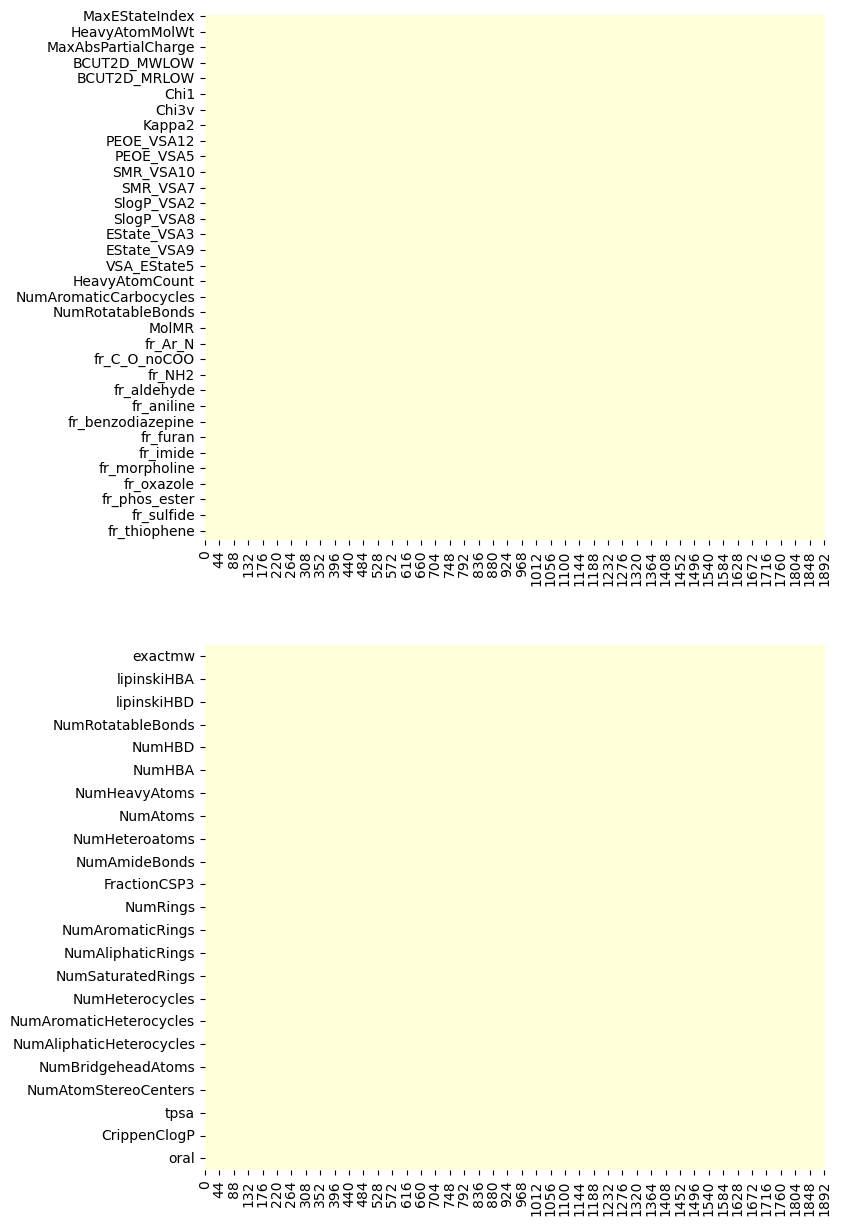

In [33]:
fig, axs = plt.subplots(2,1,figsize=(8,15))

missing_all_descriptors = sns.heatmap(all_descriptors_dataset.isna().transpose(), cmap='YlGnBu', cbar=False, ax= axs[0])
missing_rule_descriptors = sns.heatmap(rules_dataset.isna().transpose(), cmap='YlGnBu', cbar=False, ax= axs[1])

## PCA plots

### All descriptors

In [44]:
X_all_rules = all_descriptors_dataset.iloc[:,:-1]
target_oral = all_descriptors_dataset['oral']

# Scaling data
scaler = StandardScaler()
scaler.fit(X_all_rules)
X_all_rules_scaled = scaler.transform(X_all_rules)

In [46]:
# Performing PCA
pca = PCA(n_components=10)
pca.fit(X_all_rules_scaled)
pca_all_rules = pca.transform(X_all_rules_scaled)

In [47]:
# Generating Dataframe for PCA
PC1 = pca_all_rules[:,0]
PC2 = pca_all_rules[:,1]
PC3 = pca_all_rules[:,2]
label_oral = ['non oral', 'oral']
legend_oral = [label_oral[point] for point in target_oral]

zipped = list(zip(PC1, PC2, PC3, target_oral, legend_oral))
pca_df = pd.DataFrame(zipped, columns=['pc1', 'pc2', 'pc3', 'oral', 'legend_oral'])

[21.30593043  7.38016728  6.17286835  3.7632659   2.82758508  2.74100509
  2.5608451   2.41330213  2.31097659  1.95804315]


<Figure size 640x480 with 0 Axes>

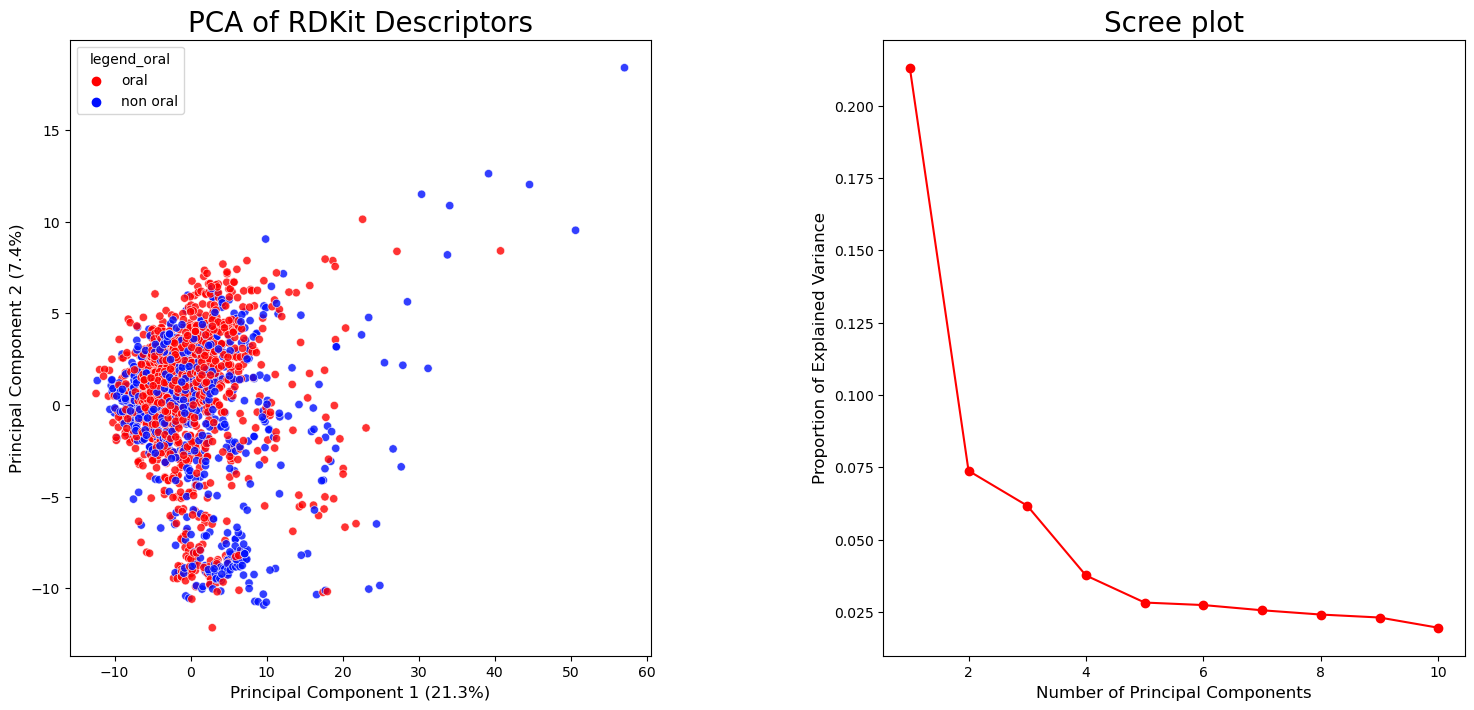

In [84]:
# 2D plot
plt.tight_layout()
fig, axs = plt.subplots(1,2, figsize=(18,8))

sns.scatterplot(
    data=pca_df, 
    x='pc1', 
    y='pc2',
    hue='legend_oral',
    ax=axs[0], palette={'oral': '#ff0000', 'non oral':'#000fff'}, alpha=0.8)
axs[0].set_title('PCA of RDKit Descriptors', fontsize=20)
axs[0].set_xlabel(f'Principal Component 1 (21.3%)', fontsize=12)
axs[0].set_ylabel(f'Principal Component 2 (7.4%)', fontsize=12)

PC_values = np.arange(pca.n_components_) + 1
axs[1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1].set_title('Scree plot', fontsize=20)
axs[1].set_xlabel('Number of Principal Components', fontsize=12)
axs[1].set_ylabel('Proportion of Explained Variance', fontsize=12)
fig.subplots_adjust(wspace=0.4)

print(pca.explained_variance_ratio_*100)

### Only rule-based

In [87]:
X_rule_based = rules_dataset.iloc[:,:-1]
target_oral = rules_dataset['oral']

# Scaling data
scaler= StandardScaler()
scaler.fit(X_rule_based)

X_rule_based_scaled = scaler.transform(X_rule_based)

In [90]:
# Performing PCA
pca = PCA(n_components=10)
pca.fit(X_rule_based_scaled)
pca_rule_based = pca.transform(X_rule_based_scaled)

In [94]:
# Generating Dataframe for PCA
PC1 = pca_rule_based[:,0]
PC2 = pca_rule_based[:,1]
PC3 = pca_rule_based[:,2]

label_oral = ['non oral', 'oral']
legend_oral = [label_oral[point] for point in target_oral]

zipped = list(zip(PC1, PC2, PC3, target_oral, legend_oral))
pca_rules_df = pd.DataFrame(zipped, columns= ['pc1', 'pc2', 'pc3', 'oral', 'legend_oral'])

Text(0.5, 1.0, 'Scree plot')

<Figure size 640x480 with 0 Axes>

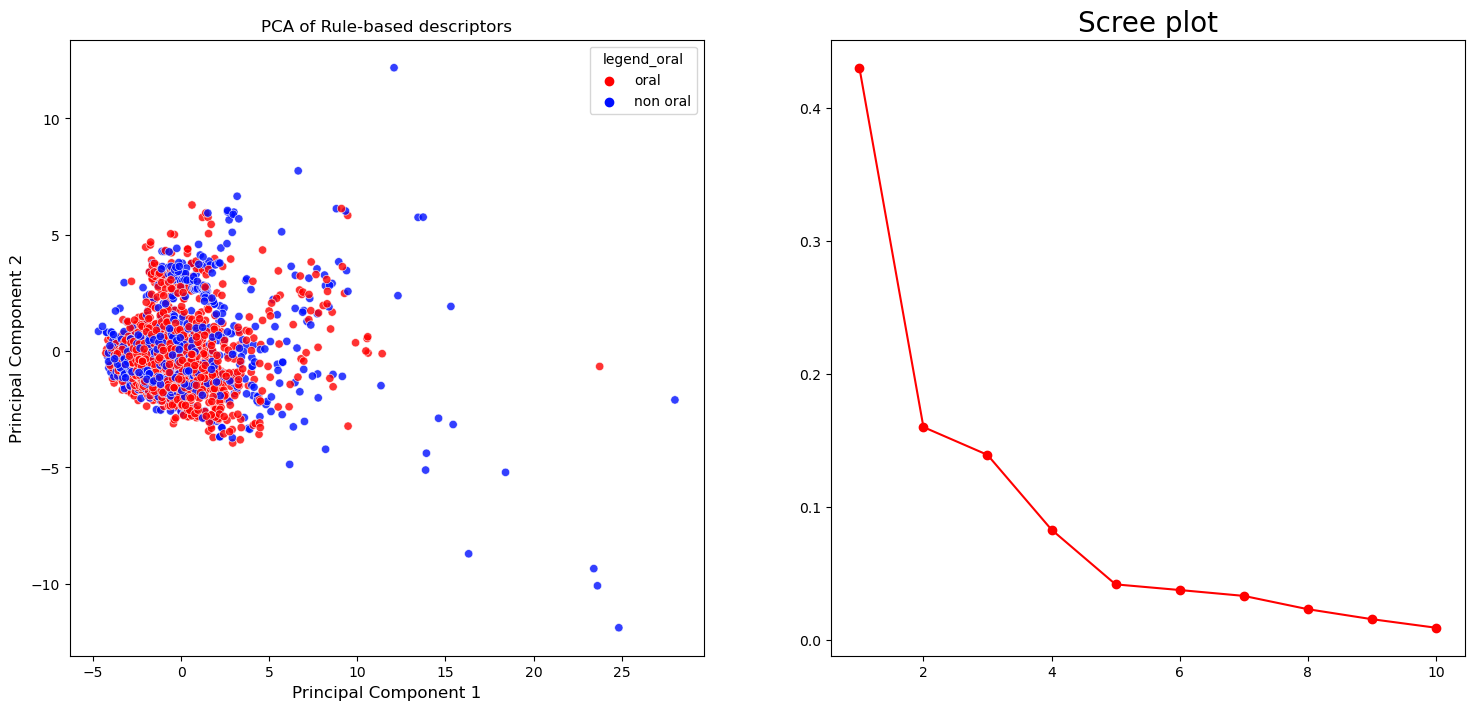

In [96]:
# 2D plot
plt.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(18,8))

sns.scatterplot(
    data= pca_rules_df,
    x='pc1',
    y='pc2',
    hue='legend_oral',
    ax=axs[0], palette={'oral': '#ff0000', 'non oral': '#000fff'}, alpha=0.8
)
axs[0].set_title('PCA of Rule-based descriptors')
axs[0].set_xlabel('Principal Component 1', fontsize=12)
axs[0].set_ylabel('Principal Component 2', fontsize=12)

PC_values = np.arange(pca.n_components_) + 1
axs[1].plot(PC_values, pca.explained_variance_ratio_, 'ro-')
axs[1].set_title('Scree plot', fontsize=20)